<h1 align="center">Facial Recognition with the Faces94 Dataset</h1>


In [5]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from scipy import linalg as la

### Helper Function to genenerate 2-D vector of flattened images (one image per person)

In [6]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

### Function to randomly sample "k" photos to get new images on which we test

In [7]:
def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        k (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

### Truncated Singular Value Decomposition implemented (minimal dimension desomposition)

In [9]:
def compact_svd(A, tol=1e-6):
    """Compute the truncated SVD of A.

    Parameters:
        A ((m,n) ndarray): The matrix (of rank r) to factor.
        tol (float): The tolerance for excluding singular values.

    Returns:
        ((m,r) ndarray): The orthonormal matrix U in the SVD.
        ((r,) ndarray): The singular values of A as a 1-D array.
        ((r,n) ndarray): The orthonormal matrix V^H in the SVD.
    """
    m, n = A.shape    # get dimentions of array
    r = max([m,n])
    B = np.copy(A.conj().T)
    T = B @ A
    val, vec = la.eigh(T) # retrieve eigenvalues and vectors 
    j = 0
    for i in val:
        if i < tol:       # if ev's are less tan tol let them be 0
            val[j] = 0.0
            r -= 1
        else:
            val[j] = i**(0.5) # square root them
        j += 1
    val = val[::-1] # flip order of eigenvalues
    val = np.copy(val[:r])
    vec = np.fliplr(vec) # flip array of vectors
    vec = vec[:, :r]
    U = A @ vec 
    U = (U.T/val[:,None]).T # create U at A @ vec[:,i] /val[i] 
    return U, val, vec.conj().T

### Class to store "training" data, with methods to find eigenface decompositions and match eigenfaces to individuals

In [15]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        self.F = get_faces(path) # initialize F matrix of image vectors
        self.mu = self.F.mean(axis=1) # initialize average vector from matrix columns
        self.Fbar = (self.F.T - self.mu).T # matrix of mean shifted face vectors
        self.U, _, _ = compact_svd(self.Fbar) # find U matrix of SVD

    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return (self.U[:,:s]).T @ A # find projection into first s eigenfaces

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        proj = self.project(g - self.mu, s) # project mean shifted g
        projf = self.project(self.Fbar, s) # project Fbar matrix
        index = -1
        norm = la.norm(projf[:,0]-proj) 
        for i in range(len(self.F[0,:])): # loop through faces to find minimum difference between vectors
            p = la.norm(projf[:,i]-proj)
            if norm > p:
                norm = p
                index = i
        return index # return index of best match

    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        x = self.find_nearest(image, s) # return index of best match
        plt.subplot(121)
        plt.imshow(image.reshape((m,n))/255, cmap="gray") # plot first image
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(self.F[:,x].reshape((m,n))/255, cmap="gray") # plot best match
        plt.axis("off")
        plt.show()
        
        

### For Example, here are some of the calculated Eigenfaces (Stored as attribute U)

In [25]:
def show(image, m=200, n=180, title="", fs =20):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    plt.imshow(image.reshape((m,n))/255, cmap="gray") # plot image in grayscale
    plt.axis("off")
    plt.title(title, fontsize=fs)
    plt.show()

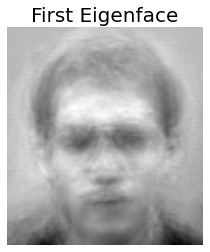

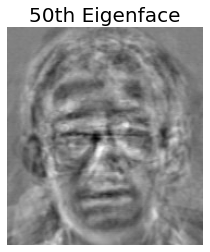

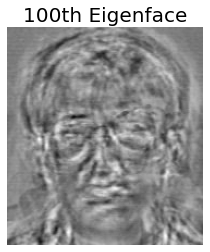

In [28]:
X = FacialRec() # initialize object X 
show(X.U[:,0], title="First Eigenface")
show(X.U[:,50], title="50th Eigenface")
show(X.U[:,100], title="100th Eigenface")

### Using the project function, we can project the image onto the span of the first "s" eigenfaces

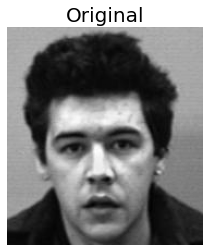

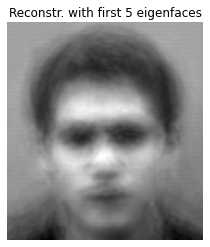

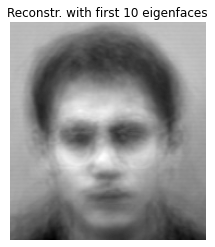

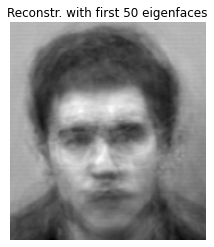

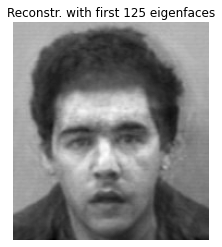

In [43]:
i = np.random.randint(0,len(X.F[0,:])) # get random column for image

j = [5,10,50,125] # values of s for projection
show(X.F[:,i], title="Original") # plot image
for s in j:
    fat = X.project(X.F[:,i],s) # project
    fat = X.U[:,:s] @ fat  # multiply by U_s
    fat = fat + X.mu # add back average face
    show(fat, title=f"Reconstr. with first {s} eigenfaces", fs=12) # plot



### Match sampled images to the corresponding face in the input data.  <br> <br> It does surprisingly well using only 38 eigenfaces! <br>

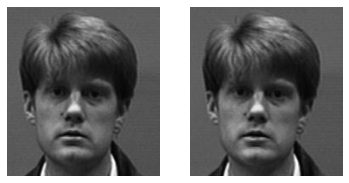

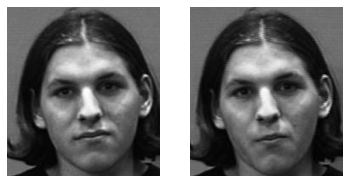

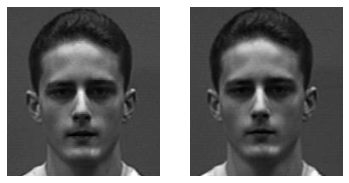

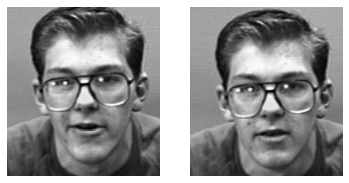

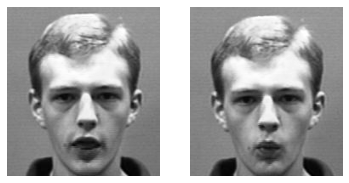

In [41]:
for test_image in sample_faces(5): # take 5 samples from data set and compare to samples in F 
    X.match(test_image)